stimulus start: 0.0, stimulus end: 1.0
simulating 426 neurons. Start: Wed Jun  8 17:52:44 2022


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
INFO       width adjusted from 20. ms to 20.1 ms [brian2.monitors.ratemonitor.adjusted_width]


sim end: Wed Jun  8 17:54:18 2022


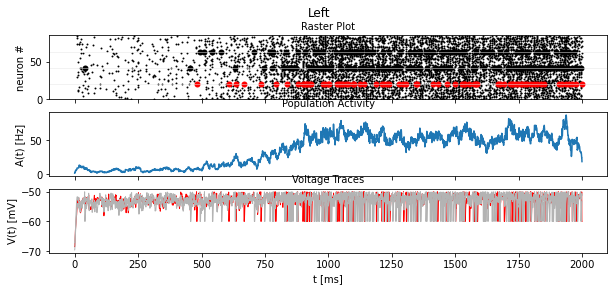

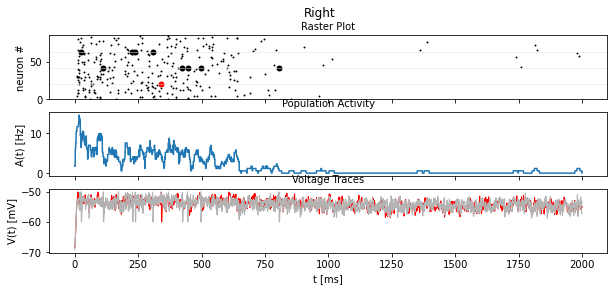

In [2]:
import wang

import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import time

b2.defaultclock.dt = 0.10 * b2.ms

%matplotlib inline
#from neurodynex3.competing_populations import decision_making

"""
A simple example to get started.
Returns:

"""
stim_start = 0. * b2.ms
stim_duration = 1000 * b2.ms
print("stimulus start: {}, stimulus end: {}".format(stim_start, stim_start+stim_duration))

results = wang.sim_decision_making_network(N_Excit=341, N_Inhib=85, weight_scaling_factor=6.0,
                                      t_stimulus_start=stim_start, t_stimulus_duration=stim_duration,
                                      coherence_level=+0.0, w_pos=2.0, mu0_mean_stimulus_Hz=250 * b2.Hz,
                                      max_sim_time=2000. * b2.ms)
plot_tools.plot_network_activity(results["rate_monitor_A"], results["spike_monitor_A"],
                                 results["voltage_monitor_A"], t_min=0. * b2.ms, avg_window_width=20. * b2.ms,
                                 sup_title="Left")
plot_tools.plot_network_activity(results["rate_monitor_B"], results["spike_monitor_B"],
                                 results["voltage_monitor_B"], t_min=0. * b2.ms, avg_window_width=20. * b2.ms,
                                 sup_title="Right")

plt.show()

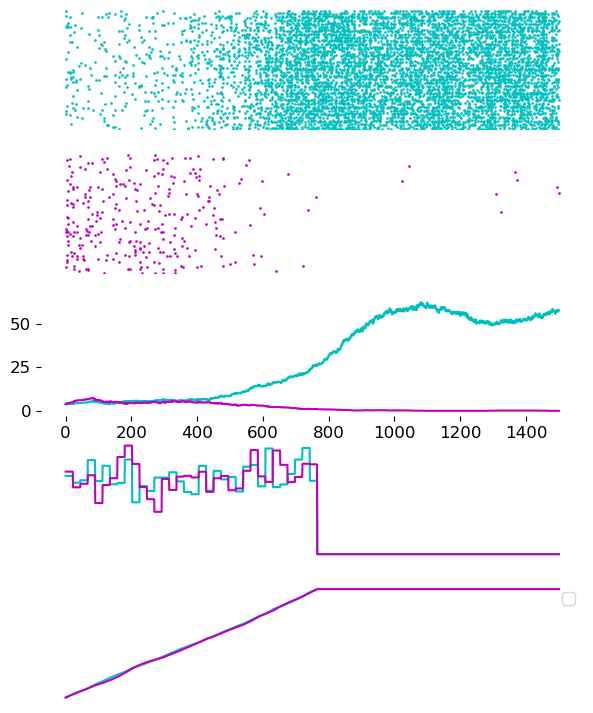

In [13]:
rate_A_bins = results['stim_info_a']
rate_B_bins = results['stim_info_b']



start_time = 0
dt = 30 
total_stim_A = np.zeros(2000)
total_stim_B = np.zeros(2000)

for i in range(40):
    total_stim_A[start_time+dt*i:start_time+dt*(i+1)] = rate_A_bins[i]
    total_stim_B[start_time+dt*i:start_time+dt*(i+1)] = rate_B_bins[i]
    
    
    
    
def time_integral(stim_info):
    #ti = sum(stim_info[0:time])
    time_integral = []
    for i in range(len(stim_info)):
        time_integral.append(sum(stim_info[0:i]))
        
    
    return time_integral

ti_A = time_integral(total_stim_A)
ti_B = time_integral(total_stim_B)


def get_spike_train_ts_indices(spike_train):
    """
    Helper. Extracts the spikes within the time window from the spike train
    """
    
    t_min = 0
    t_max = 2000
    
    ts = spike_train/b2.ms
    # spike_within_time_window = (ts >= t_min) & (ts <= t_max)
    # idx_spikes = numpy.where(spike_within_time_window)
    idx_spikes = (ts >= t_min) & (ts <= t_max)
    ts_spikes = ts[idx_spikes]
    return idx_spikes, ts_spikes



import numpy

plt.style.use('default')
plt.rcParams['figure.figsize'] = (7, 9)
plt.rcParams['font.size'] = 12

fig, (ax_A, ax_B, rate_ax, stim_ax, ti_ax) = plt.subplots(5, 1)
spikemon_A = results["spike_monitor_A"]
spikemon_B = results["spike_monitor_B"]


all_spike_trains_A = spikemon_A.spike_trains()

neuron_counter = 0
spike_train_idx_list =numpy.arange(0,85)

for neuron_index in spike_train_idx_list:
    idx_spikes, ts_spikes = get_spike_train_ts_indices(all_spike_trains_A[neuron_index])
    ax_A.scatter(ts_spikes, neuron_counter * numpy.ones(ts_spikes.shape),
                      marker=".", c="c", s=15, lw=0)
    neuron_counter += 1
ax_A.set_ylim([0, neuron_counter])

#ax.spines['right'].set_visible(False)
ax_A.spines['top'].set_visible(False)        # 왼쪽 축을 가운데 위치로 이동
ax_A.spines['right'].set_visible(False)    
ax_A.spines['left'].set_visible(False)    
ax_A.spines['bottom'].set_visible(False)    


ax_A.get_xaxis().set_visible(False)
ax_A.get_yaxis().set_visible(False)


all_spike_trains_B = spikemon_B.spike_trains()
neuron_counter = 0
for neuron_index in spike_train_idx_list:
    idx_spikes, ts_spikes = get_spike_train_ts_indices(all_spike_trains_B[neuron_index])
    ax_B.scatter(ts_spikes, neuron_counter * numpy.ones(ts_spikes.shape),
                      marker=".", c="m", s=15, lw=0)
    neuron_counter += 1
ax_B.set_ylim([0, neuron_counter])

#ax.spines['right'].set_visible(False)
ax_B.spines['top'].set_visible(False)        # 왼쪽 축을 가운데 위치로 이동
ax_B.spines['right'].set_visible(False)    
ax_B.spines['left'].set_visible(False)    
ax_B.spines['bottom'].set_visible(False)    


ax_B.get_xaxis().set_visible(False)
ax_B.get_yaxis().set_visible(False)


#########

rate_excit_A =  results['rate_monitor_A']
rate_excit_B =  results['rate_monitor_B']
rate_inhib =  results['rate_monitor_inhib']

#rate_monitor_0 =  results_0['rate_monitor_inhib']


window_width = 150.1 * b2.ms
(ax_rate) = plt.plot(figsize=(10,4))
t_max  = 1500
t_min = 0 
ts = rate_excit_A.t / b2.ms
idx_rate = (ts >= t_min) & (ts <= t_max)
smoothed_rates_A = rate_excit_A.smooth_rate(window="flat", width=window_width)/b2.Hz
smoothed_rates_B = rate_excit_B.smooth_rate(window="flat", width=window_width)/b2.Hz
smoothed_rates_ihb = rate_inhib.smooth_rate(window="flat", width=window_width)/b2.Hz

rate_ax.plot(ts[idx_rate], smoothed_rates_A[idx_rate],'c')
rate_ax.plot(ts[idx_rate], smoothed_rates_B[idx_rate], 'm')
#rate_ax.plot(ts[idx_rate], smoothed_rates_ihb[idx_rate])

plt.xlabel('Time (ms)')
plt.ylabel('Averaged Firing Rate (spikes/s)')

labels= ["Left","Right", "Inhibitory"]

plt.legend(labels)


rate_ax.spines['top'].set_visible(False)        # 왼쪽 축을 가운데 위치로 이동
rate_ax.spines['right'].set_visible(False)    
rate_ax.spines['left'].set_visible(False)    
rate_ax.spines['bottom'].set_visible(False)   

#stim_ax.xlabel('Time (ms)')
#stim_ax.ylabel('Sample Stimulus')

#rate_ax.get_xaxis().set_visible(False)
#rate_ax.get_yaxis().set_visible(False)


###########---------------------Stimulation Information -----------------############
stim_ax.plot(total_stim_A,'c')
stim_ax.plot(total_stim_B,'m')

#stim_ax.xlabel('Time (ms)')
#stim_ax.ylabel('Sample Stimulus')
stim_ax.get_xaxis().set_visible(False)
stim_ax.get_yaxis().set_visible(False)

#ax.spines['right'].set_visible(False)
stim_ax.spines['top'].set_visible(False)        # 왼쪽 축을 가운데 위치로 이동
stim_ax.spines['right'].set_visible(False)    
stim_ax.spines['left'].set_visible(False)    
stim_ax.spines['bottom'].set_visible(False)   


############------- time integral------------ #######################

ti_ax.plot(ti_A,'c')
ti_ax.plot(ti_B,'m')

#stim_ax.xlabel('Time (ms)')
#stim_ax.ylabel('Sample Stimulus')
ti_ax.get_xaxis().set_visible(False)
ti_ax.get_yaxis().set_visible(False)

#ax.spines['right'].set_visible(False)
ti_ax.spines['top'].set_visible(False)        # 왼쪽 축을 가운데 위치로 이동
ti_ax.spines['right'].set_visible(False)    
ti_ax.spines['left'].set_visible(False)    
ti_ax.spines['bottom'].set_visible(False)   

In [8]:
import numpy
import brian2 as b2
import get_decision_time as gt

import f_decision_time as f_dt

In [9]:
gt.get_decision_time(results, rate_threshold=40.6*b2.Hz)

(0.8573 * second, 'A')

In [17]:
f_dt.get_decision_time(results, rate_threshold=10.6*b2.Hz)

(0.5722 * second, 0. * second)

In [10]:
coherence_levels = [-0.1, -0.5]  # for negative values, B is the correct decision.
nr_repetitions = 1